In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np
from corners import *
import random

In [2]:
def loadImages():
    images = []
    for i in range(1,11):
        location = r"images/%d.jpg"%i
        img = rgb2gray(mpl.image.imread(location))
        images.append(img)
    return images

In [3]:
def getFeaturePoints(img):
    result = cornerDetect(img, winSize=21, k=0.04, thd=1e14, type=1)
    # Non maximum suppression
    tempScale = np.pad(result, 2, mode='constant')
    width, height = tempScale.shape
    for x in range(2, width-2):
        for y in range(2, height-2):
            if tempScale[x][y] != np.max(tempScale[x-2:x+3, y-2:y+3]):
                tempScale[x][y] = 0
    result = tempScale[2:width-2, 2:height-2]
    y, x = np.nonzero(result)
    print('Number of corner : %d'%y.shape)
    return x,y

In [4]:
def getFeatureDescriptors(X, Y, winSize, img):
    neighbors = []
    descriptors = []
    newPoint = []
    for x, y in zip(X,Y):
        patch_center = np.array([x, y])
        image = np.array(img)
        patch_size = winSize
        patch_x = int(patch_center[1] - patch_size / 2.)
        patch_y = int(patch_center[0] - patch_size / 2.)
        if patch_x < 0 or patch_y < 0:
            #print('!')
            continue
        else:
            patch_image = image[patch_x:patch_x+patch_size, patch_y:patch_y+patch_size]
            #patch_image = np.float32(patch_image)/255.0
            patch_image = patch_image.astype(np.uint8)
            neighbors.append(patch_image.flatten())
            newPoint.append([x,y])
    return np.array(newPoint), np.array(neighbors)

In [80]:
def match2Images(desc1, keypoint1, desc2, keypoint2, type='ncc', th = 2):
    dist = []
    keypoints = []
    
    for des1, key1 in zip(desc1, keypoint1):
        for des2, key2 in zip(desc2, keypoint2):
            if type == 'ncc':
                des1Norm = des1 / np.sqrt((np.sum(des1**2)))
                des2Norm = des2 / np.sqrt((np.sum(des2**2)))
                distance = np.dot(des1Norm.T,des2Norm)
                dist.append(distance)
                keypoints.append((key1, key2))
            elif type == 'euclidean':
                dist.append(np.sqrt(np.sum((des1-des2)**2)))
                keypoints.append((key1, key2))
            else:
                print('type error : use [ncc] or [euclidean]')
                
    dist = np.array(dist)
    keypoints = np.array(keypoints)
    if type == 'ncc':
        print('#ncc# min : %0.0f, max : %0.0f'%(min(dist),max(dist)))
        temp = dist < th
        idxOfCorrectMatching = np.nonzero(temp)
    elif type == 'euclidean':
        print('#euclidean#  min : %0.0f, max : %0.0f'%(min(dist),max(dist)))
        temp = dist < th
        idxOfCorrectMatching = np.nonzero(temp)
    else:
        print('type error : use [ncc] or [euclidean]')
    candidateCorrespondences = []
    for i in idxOfCorrectMatching:
        candidateCorrespondences.append(keypoints[i])
    return np.array(candidateCorrespondences).reshape(len(candidateCorrespondences[0]),2,2)

In [6]:
def refineMatches(feature_points, match_list):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-6-bbdcf7edc8fc>, line 2)

그레이스케일된 이미지를 불러온다. 리스트로 10장

In [7]:
images = loadImages()

각 이미지의 코너를 DETECT한다.
이미지 마다 DETECT된 코너좌표를 리스트로 저장 imgX[0~9], imgY[0~9]
# 10장 다 해야해서 오래걸림;;

Number of corner : 483
Number of corner : 930
Number of corner : 665
Number of corner : 422
Number of corner : 469
Number of corner : 235
Number of corner : 503
Number of corner : 933
Number of corner : 1541
Number of corner : 1558


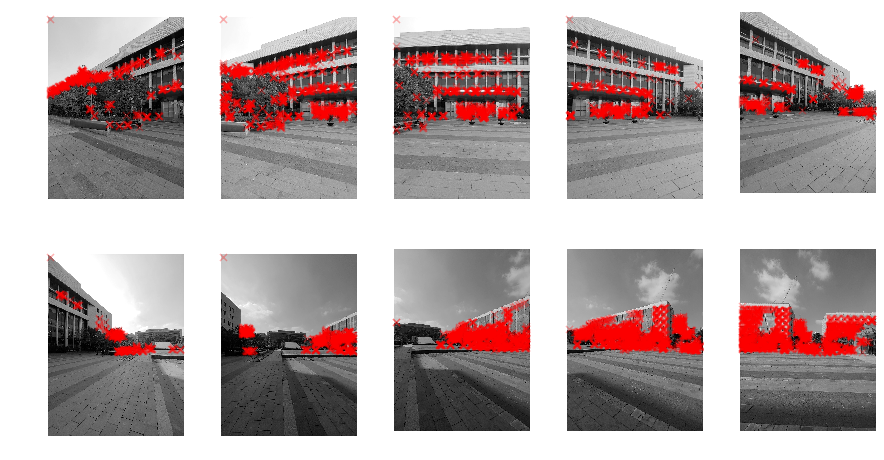

In [8]:
imgX = []
imgY = []
fig = plt.figure(figsize=(15,8))
for i in range(10):
    X,Y = getFeaturePoints(images[i])
    imgX.append(X)
    imgY.append(Y)
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(images[i], cmap='gray')
    ax.scatter(imgX[i], imgY[i], 50, marker='x', alpha = 0.3,color='r')
    ax.axis('off')
plt.show()

test로 첫번째 두번째 이미지의 flatten된 feature를 뽑는다. 

In [50]:
keypoint1, desc1 = getFeatureDescriptors(imgX[0], imgY[0], 5, images[0])

In [51]:
keypoint2, desc2 = getFeatureDescriptors(imgX[1], imgY[1], 5, images[1])

feature사이에 거리를 기준으로 일정 쓰레시홀드 안에 들어오는 쌍들을 찾는다. 

In [52]:
candidate = match2Images(desc1,keypoint1,desc2,keypoint2,'ncc')
print('find %d matches'%len(candidate))

#ncc# min : 1, max : 844
find 143 matches


매칭쌍들의 좌표를 스플릿하여 저장

In [53]:
img1X_candi = candidate[:,:1,:1].reshape(len(candidate))
img1Y_candi = candidate[:,:1,1:].reshape(len(candidate))
img2X_candi = candidate[:,1:,:1].reshape(len(candidate))
img2Y_candi = candidate[:,1:,1:].reshape(len(candidate))

각각의 이미지에 매칭쌍 좌표 출력

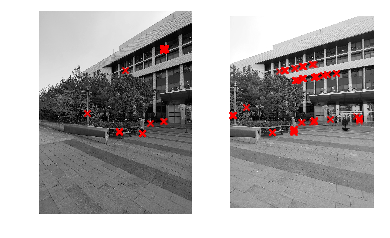

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(images[0], cmap='gray')
ax1.scatter(img1X_candi, img1Y_candi, marker='x', alpha = 0.7,color='r')
ax1.axis('off')
ax2.imshow(images[1], cmap='gray')
ax2.scatter(img2X_candi, img2Y_candi, marker='x', alpha = 0.7,color='r')
ax2.axis('off')
plt.show()

아홉번째와 열번째 이미지 도 마찬가지로 테스트

In [198]:
keypoint8, desc8 = getFeatureDescriptors(imgX[2], imgY[2], 30, images[2])
keypoint9, desc9 = getFeatureDescriptors(imgX[3], imgY[3], 30, images[3])

In [200]:
candidate = match2Images(desc8,keypoint8,desc9,keypoint9,'euclidean', 250)
print('find %d matches'%len(candidate))

#euclidean#  min : 244, max : 332
find 14 matches


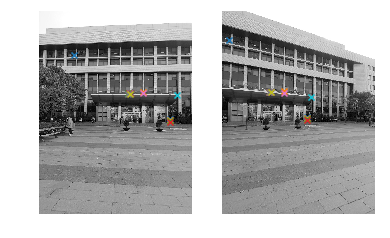

In [201]:
img1X_candi = candidate[:,:1,:1].reshape(len(candidate))
img1Y_candi = candidate[:,:1,1:].reshape(len(candidate))
img2X_candi = candidate[:,1:,:1].reshape(len(candidate))
img2Y_candi = candidate[:,1:,1:].reshape(len(candidate))

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(images[2], cmap='gray')
ax2.imshow(images[3], cmap='gray')
for x1, y1, x2, y2 in zip(img1X_candi, img1Y_candi, img2X_candi, img2Y_candi):
    ax1.scatter(x1, y1, marker='x')
    ax2.scatter(x2, y2, marker='x')
ax1.axis('off')
ax2.axis('off')
plt.show()

test

In [147]:
#
# Computers a homography from 4-correspondences
#
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)
    lamda, eig = np.linalg.eig(matrixA.T * matrixA)
    
    minimum_idx = np.argmin(lamda)
    h = np.reshape(eig[minimum_idx], (3, 3))

    h = (1/h.item(8)) * h
    return h

In [148]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/(estimatep2.item(2) + 1e-8))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [149]:
def ransac(corr, thresh):
    maxInliers = []
    min_residual = -99999
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []
        
        residual = 0
        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            residual = residual + d
            if d < thresh:
                inliers.append(corr[i])
            
        avg_residual = residual / len(corr)

        if len(inliers) > len(maxInliers):
            finalH = h
            maxInliers = inliers
            
        print("step: ", i, " average residual: ", avg_residual, " NumInliers: ", len(inliers))
        
    return finalH, maxInliers

In [218]:
correspondenceList = []
for x1, y1, x2, y2 in zip(img1X_candi, img1Y_candi, img2X_candi, img2Y_candi):
        correspondenceList.append([x1, y1, x2, y2])
corrs = np.matrix(correspondenceList)
inlier_thresh = 500
finalH, inliers = ransac(corrs, inlier_thresh)

step:  13  average residual:  547.4307302245768  NumInliers:  7
step:  13  average residual:  550.9287551707922  NumInliers:  7
step:  13  average residual:  551.2143504156551  NumInliers:  7
step:  13  average residual:  550.3612348423504  NumInliers:  7
step:  13  average residual:  551.5560283035683  NumInliers:  7
step:  13  average residual:  551.8735551388052  NumInliers:  7
step:  13  average residual:  552.2170006117028  NumInliers:  7
step:  13  average residual:  551.8547664102819  NumInliers:  7
step:  13  average residual:  541.5562170698112  NumInliers:  7
step:  13  average residual:  549.2230473932065  NumInliers:  7
step:  13  average residual:  549.7269722322284  NumInliers:  7
step:  13  average residual:  550.3015882691036  NumInliers:  7
step:  13  average residual:  550.6460096966847  NumInliers:  7
step:  13  average residual:  550.3485749491934  NumInliers:  7
step:  13  average residual:  549.0441638513379  NumInliers:  7
step:  13  average residual:  549.805146

step:  13  average residual:  551.2505017024544  NumInliers:  7
step:  13  average residual:  550.8346768851995  NumInliers:  7
step:  13  average residual:  545.0941151829903  NumInliers:  7
step:  13  average residual:  546.6033806482744  NumInliers:  7
step:  13  average residual:  551.175419241343  NumInliers:  7
step:  13  average residual:  549.5580750921777  NumInliers:  7
step:  13  average residual:  550.561232933744  NumInliers:  7
step:  13  average residual:  550.1149195881246  NumInliers:  7
step:  13  average residual:  550.0250587256367  NumInliers:  7
step:  13  average residual:  551.2210242338876  NumInliers:  7
step:  13  average residual:  549.7355905917813  NumInliers:  7
step:  13  average residual:  550.5494243779464  NumInliers:  7
step:  13  average residual:  551.2551917704125  NumInliers:  7
step:  13  average residual:  551.2018553430156  NumInliers:  7
step:  13  average residual:  551.2552179168973  NumInliers:  7
step:  13  average residual:  550.14994028

step:  13  average residual:  550.5480557195787  NumInliers:  7
step:  13  average residual:  552.1639278521927  NumInliers:  7
step:  13  average residual:  551.2282282701252  NumInliers:  7
step:  13  average residual:  543.9713146666539  NumInliers:  7
step:  13  average residual:  549.8049030287318  NumInliers:  7
step:  13  average residual:  550.9536334588709  NumInliers:  7
step:  13  average residual:  550.8989193976417  NumInliers:  7
step:  13  average residual:  550.6679043612769  NumInliers:  7
step:  13  average residual:  549.735465042576  NumInliers:  7
step:  13  average residual:  550.8610849644807  NumInliers:  7
step:  13  average residual:  550.9949525959871  NumInliers:  7
step:  13  average residual:  550.8610849644807  NumInliers:  7
step:  13  average residual:  547.6439971934682  NumInliers:  7
step:  13  average residual:  550.7278017003691  NumInliers:  7
step:  13  average residual:  550.809288792743  NumInliers:  7
step:  13  average residual:  550.10719333

step:  13  average residual:  550.0782064602106  NumInliers:  7
step:  13  average residual:  550.0512411557842  NumInliers:  7
step:  13  average residual:  552.1805902379585  NumInliers:  7
step:  13  average residual:  550.9636648403929  NumInliers:  7
step:  13  average residual:  551.8749041280302  NumInliers:  7
step:  13  average residual:  550.8989193976417  NumInliers:  7
step:  13  average residual:  549.6980742647563  NumInliers:  7
step:  13  average residual:  550.082776316277  NumInliers:  7
step:  13  average residual:  550.6780628042576  NumInliers:  7
step:  13  average residual:  552.9107513391589  NumInliers:  7
step:  13  average residual:  551.0292611106454  NumInliers:  7
step:  13  average residual:  551.2428702271146  NumInliers:  7
step:  13  average residual:  550.5276855278402  NumInliers:  7
step:  13  average residual:  550.140297647085  NumInliers:  7
step:  13  average residual:  550.5155652789401  NumInliers:  7
step:  13  average residual:  549.58376048

step:  13  average residual:  551.218806574043  NumInliers:  7
step:  13  average residual:  548.45788552502  NumInliers:  7
step:  13  average residual:  551.8126697449217  NumInliers:  7
step:  13  average residual:  549.6354001429391  NumInliers:  7
step:  13  average residual:  549.6638850737469  NumInliers:  7
step:  13  average residual:  550.0023010111685  NumInliers:  7
step:  13  average residual:  551.4095800151391  NumInliers:  7
step:  13  average residual:  550.8963172871557  NumInliers:  7
step:  13  average residual:  550.5575133279432  NumInliers:  7
step:  13  average residual:  551.0017223404159  NumInliers:  7
step:  13  average residual:  548.3852324272196  NumInliers:  7
step:  13  average residual:  551.8870312785714  NumInliers:  7
step:  13  average residual:  549.9570959991668  NumInliers:  7
step:  13  average residual:  547.6861608818186  NumInliers:  7
step:  13  average residual:  551.2272024541136  NumInliers:  7
step:  13  average residual:  549.623387744

step:  13  average residual:  548.5573853859627  NumInliers:  7
step:  13  average residual:  550.5547558472402  NumInliers:  7
step:  13  average residual:  22738.38459006738  NumInliers:  0
step:  13  average residual:  551.2722156148932  NumInliers:  7
step:  13  average residual:  551.1124661937937  NumInliers:  7
step:  13  average residual:  550.916047360772  NumInliers:  7
step:  13  average residual:  550.0721645549982  NumInliers:  7
step:  13  average residual:  549.8661656716068  NumInliers:  7
step:  13  average residual:  549.9586825904389  NumInliers:  7
step:  13  average residual:  548.9321177834724  NumInliers:  7
step:  13  average residual:  550.3555482647673  NumInliers:  7
step:  13  average residual:  551.0449646848372  NumInliers:  7
step:  13  average residual:  551.3953193627576  NumInliers:  7
step:  13  average residual:  553.9533368830952  NumInliers:  6
step:  13  average residual:  550.1110560677793  NumInliers:  7
step:  13  average residual:  552.1129126

step:  13  average residual:  546.6605330975157  NumInliers:  7
step:  13  average residual:  551.6612829569942  NumInliers:  7
step:  13  average residual:  550.5540457682656  NumInliers:  7
step:  13  average residual:  549.8516620588566  NumInliers:  7
step:  13  average residual:  553.8823954152076  NumInliers:  6
step:  13  average residual:  550.5556850162222  NumInliers:  7
step:  13  average residual:  550.0685293696766  NumInliers:  7
step:  13  average residual:  549.5880460640036  NumInliers:  7
step:  13  average residual:  553.6247920236691  NumInliers:  6
step:  13  average residual:  549.8301281583705  NumInliers:  7
step:  13  average residual:  550.2119616523954  NumInliers:  7
step:  13  average residual:  550.2724004466087  NumInliers:  7
step:  13  average residual:  551.4393595285729  NumInliers:  7
step:  13  average residual:  553.3135673239343  NumInliers:  6
step:  13  average residual:  545.1857997707903  NumInliers:  7
step:  13  average residual:  550.963664

In [219]:
len(img1X_candi)

14

In [220]:
len(correspondenceList)

14

In [221]:
inliers

[matrix([[183, 229,  38, 153]], dtype=int64),
 matrix([[546, 424, 325, 421]], dtype=int64),
 matrix([[468, 433, 246, 423]], dtype=int64),
 matrix([[471, 433, 249, 423]], dtype=int64),
 matrix([[474, 433, 252, 423]], dtype=int64),
 matrix([[482, 433, 260, 424]], dtype=int64),
 matrix([[545, 433, 324, 429]], dtype=int64),
 matrix([[468, 436, 246, 423]], dtype=int64),
 matrix([[477, 436, 255, 424]], dtype=int64),
 matrix([[722, 443, 469, 452]], dtype=int64),
 matrix([[686, 567, 445, 557]], dtype=int64),
 matrix([[686, 570, 445, 560]], dtype=int64),
 matrix([[686, 578, 445, 569]], dtype=int64),
 matrix([[686, 581, 445, 572]], dtype=int64)]

In [222]:
inliers = np.array(inliers).reshape(-1, 4)

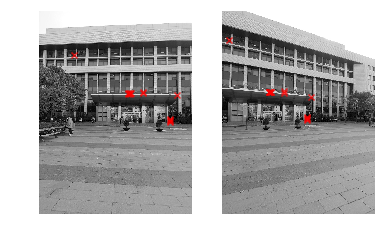

In [223]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(images[2], cmap='gray')
ax1.scatter(inliers[:, 0], inliers[:, 1], marker='x', alpha = 0.7,color='r')
ax1.axis('off')
ax2.imshow(images[3], cmap='gray')
ax2.scatter(inliers[:, 2], inliers[:, 3], marker='x', alpha = 0.7,color='r')
ax2.axis('off')
plt.show()

In [121]:
finalH

matrix([[-4.78502825e+04, -3.34071753e+04, -6.52242452e+04],
        [ 1.34996944e+05,  1.23739040e+05,  1.99558474e+05],
        [ 2.28794017e+03,  5.00267437e+01,  1.00000000e+00]])

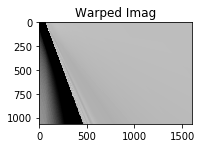

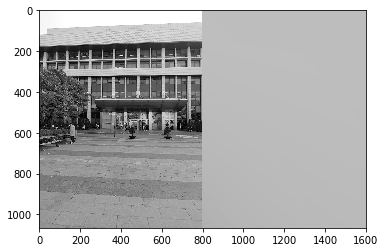

In [227]:
dst = cv2.warpPerspective(images[3],finalH,(images[2].shape[1] + images[3].shape[1], images[2].shape[0]))
plt.subplot(122)
plt.imshow(dst,cmap='gray')
plt.title('Warped Imag')
plt.show()
plt.figure()
dst[0:images[2].shape[0], 0:images[2].shape[1]] = images[2]
#cv2.imwrite(‘output.jpg’,dst)
plt.imshow(dst,cmap='gray')
plt.show()